<a href="https://colab.research.google.com/github/SHodapp117/Applied-Machine-Learning/blob/main/Weekly_price_viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'dapperlabs-data' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

## Reference SQL syntax from the original job
Use the ```jobs.query```
[method](https://cloud.google.com/bigquery/docs/reference/rest/v2/jobs/query) to
return the SQL syntax from the job. This can be copied from the output cell
below to edit the query now or in the future. Alternatively, you can use
[this link](https://console.cloud.google.com/bigquery?j=dapperlabs-data:US:bquxjob_5d9dc4d5_18bb4415d62)
back to BigQuery to edit the query within the BigQuery user interface.

In [2]:
# Running this code will display the query used to generate your previous job

job = client.get_job('bquxjob_5d9dc4d5_18bb4415d62') # Job ID inserted based on the query results selected to explore
print(job.query)

WITH WeeklyAverages AS (
  SELECT
    m.moment_edition_tier,
    DATE_TRUNC(m.pack_opened_date, WEEK) AS week_start,
    AVG(CAST(l.listing_price AS NUMERIC)) AS weekly_average
  FROM
    `dapperlabs-data.production_berkeley_ds_source.berkeley_ds_source_nfl_moments` AS m
  LEFT JOIN
    `dapperlabs-data.production_berkeley_ds_source.berkeley_ds_source_nfl_historical_listings` AS l
  ON
    m.flow_moment_id = l.flow_moment_id
  WHERE
    l.listing_price IS NOT NULL
    AND m.pack_opened_date IS NOT NULL
    AND EXTRACT(DATE FROM m.pack_acquired_date) >= DATE_SUB(CURRENT_DATE(), INTERVAL 1 YEAR)
  GROUP BY
    m.moment_edition_tier,
    week_start
)
SELECT
  moment_edition_tier,
  week_start,
  IFNULL(AVG(weekly_average), 0) AS average_listing_price
FROM
  WeeklyAverages
GROUP BY
  moment_edition_tier,
  week_start
ORDER BY
  moment_edition_tier,
  week_start;



# Result set loaded from BigQuery job as a DataFrame
Query results are referenced from the Job ID ran from BigQuery and the query
does not need to be re-run to explore results. The ```to_dataframe```
[method](https://googleapis.dev/python/bigquery/latest/generated/google.cloud.bigquery.job.QueryJob.html#google.cloud.bigquery.job.QueryJob.to_dataframe)
downloads the results to a Pandas DataFrame by using the BigQuery Storage API.

To edit query syntax, you can do so from the BigQuery SQL editor or in the
```Optional:``` sections below.

In [3]:
# Running this code will read results from your previous job

job = client.get_job('bquxjob_5d9dc4d5_18bb4415d62') # Job ID inserted based on the query results selected to explore
results = job.to_dataframe()
df =results

## Show descriptive statistics using describe()
Use the ```pandas DataFrame.describe()```
[method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html)
to generate descriptive statistics. Descriptive statistics include those that
summarize the central tendency, dispersion and shape of a dataset’s
distribution, excluding ```NaN``` values. You may also use other Python methods
to interact with your data.

In [4]:
results.describe()

<ipython-input-4-b28fad917268>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  results.describe()


,moment_edition_tier,week_start,average_listing_price
count,205,205,205
unique,5,76,204
top,COMMON,2023-11-05 00:00:00+00:00,2.000000000
freq,76,5,2
first,NaN,2022-01-23 00:00:00+00:00,NaN
last,NaN,2023-11-05 00:00:00+00:00,NaN


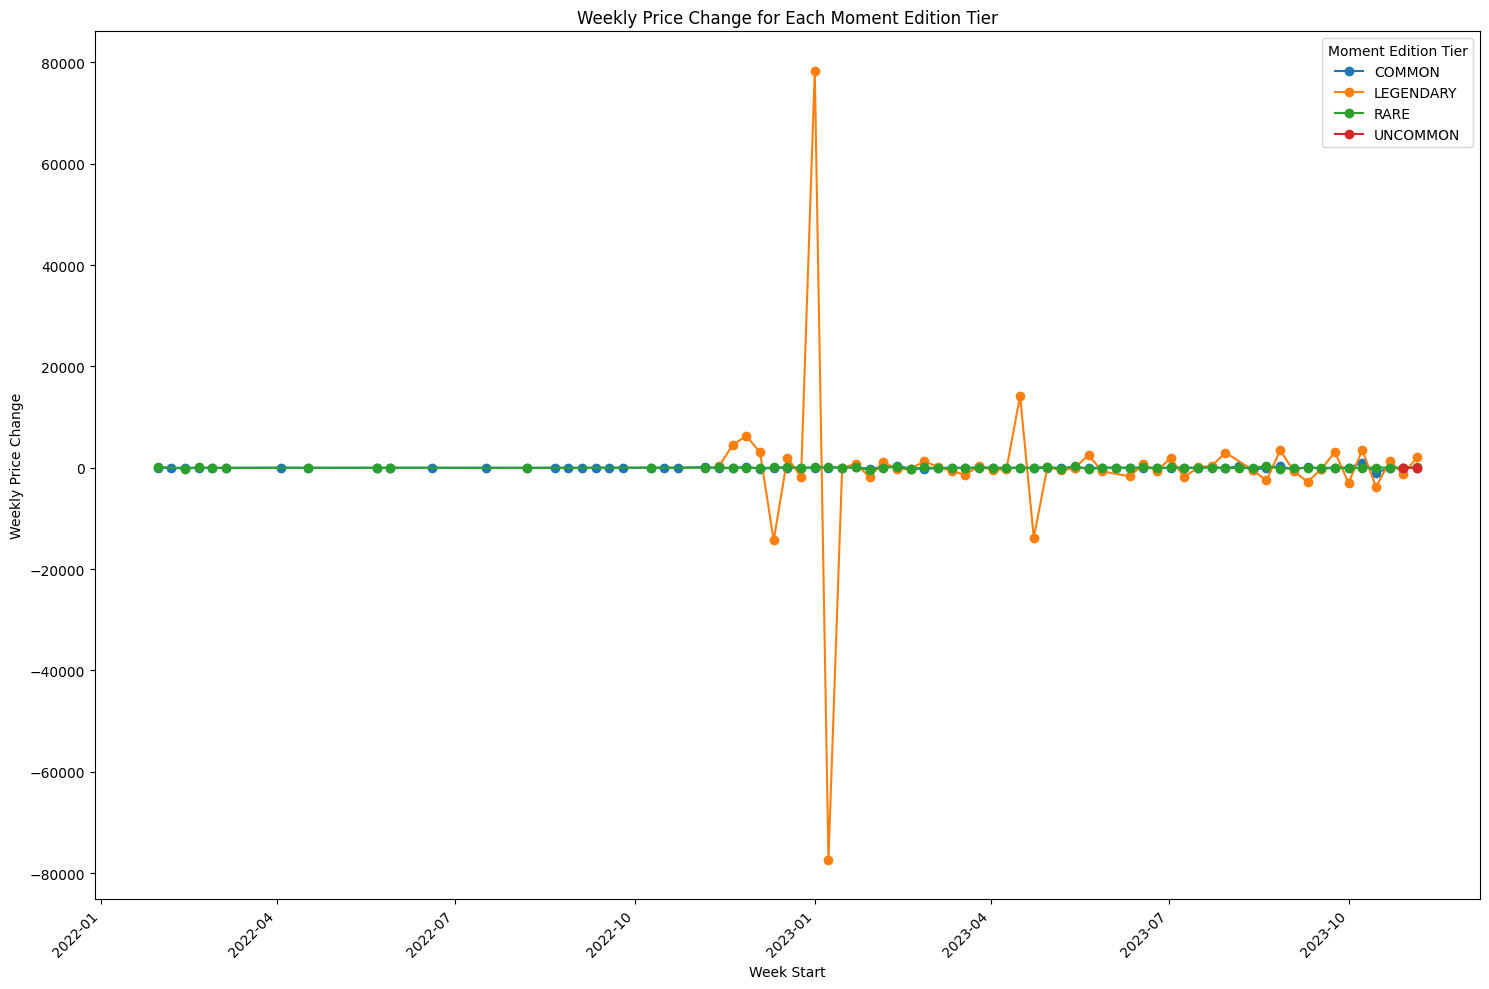

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
# Convert 'week_start' to datetime
df['week_start'] = pd.to_datetime(df['week_start'])

# Convert 'average_listing_price' to numeric
df['average_listing_price'] = pd.to_numeric(df['average_listing_price'])

# Sort the DataFrame by 'moment_edition_tier' and 'week_start'
df = df.sort_values(by=['moment_edition_tier', 'week_start'])

# Calculate weekly price change
df['weekly_price_change'] = df.groupby('moment_edition_tier')['average_listing_price'].diff()

# Filter out 'Ultimate'
df_filtered = df[df['moment_edition_tier'] != 'ULTIMATE']

# Pivot the DataFrame for easier plotting
df_pivot = df_filtered.pivot(index='week_start', columns='moment_edition_tier', values='weekly_price_change')

# Plotting
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed
for moment_tier, group in df_filtered.groupby('moment_edition_tier'):
    plt.plot(group['week_start'], group['weekly_price_change'], marker='o', label=moment_tier)

plt.title('Weekly Price Change for Each Moment Edition Tier')
plt.xlabel('Week Start')
plt.ylabel('Weekly Price Change')
plt.legend(title='Moment Edition Tier')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


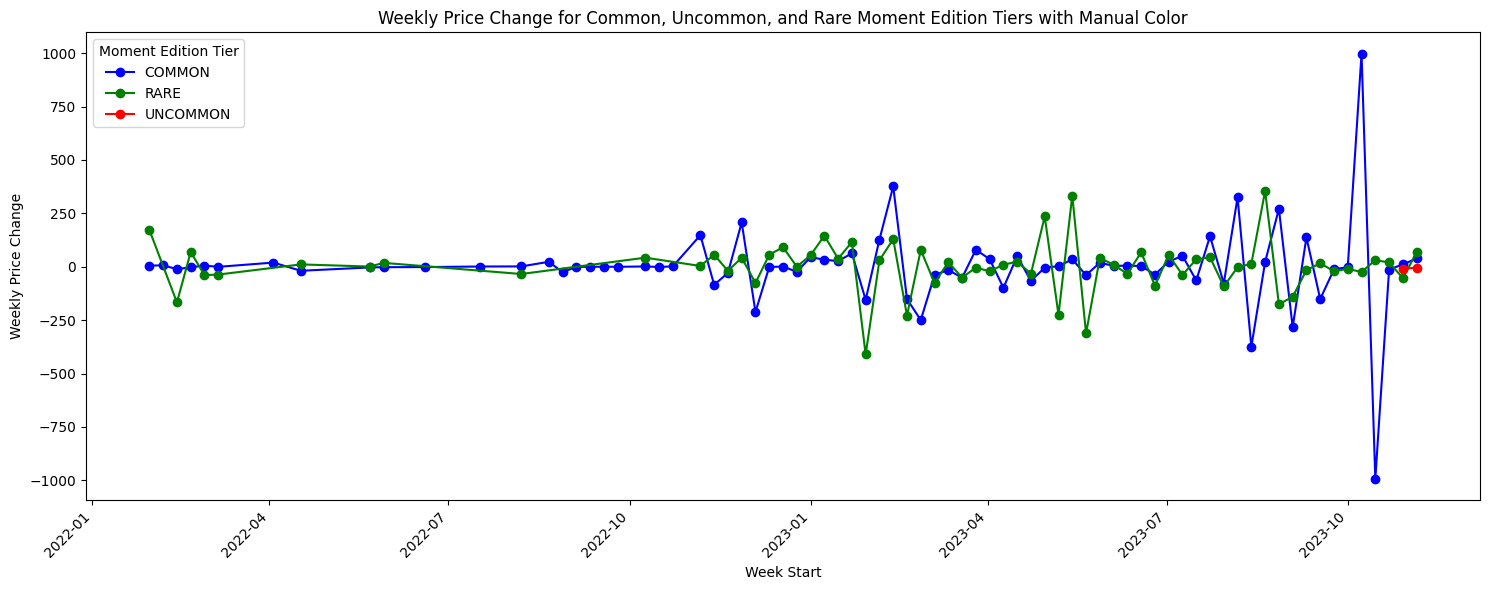

In [8]:
# Filter out 'Ultimate'
df_filtered = df[~df['moment_edition_tier'].isin(['LEGENDARY', 'ULTIMATE'])]

# Plot only 'Common' and 'Rare' with manual color setting
plt.figure(figsize=(15, 6))
for moment_tier, group in df_filtered[df_filtered['moment_edition_tier'].isin(['COMMON', 'UNCOMMON', 'RARE'])].groupby('moment_edition_tier'):
    color = {'COMMON': 'blue', 'UNCOMMON': 'red', 'RARE': 'green'}.get(moment_tier, 'black')  # Set the color manually
    plt.plot(group['week_start'], group['weekly_price_change'], marker='o', label=moment_tier, color=color)

plt.title('Weekly Price Change for Common, Uncommon, and Rare Moment Edition Tiers with Manual Color')
plt.xlabel('Week Start')
plt.ylabel('Weekly Price Change')
plt.legend(title='Moment Edition Tier')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()